In [14]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import balanced_accuracy_score

from utils_data_structures import col_prefixes

In [15]:
grouped_df = pd.read_csv('sorare_data/large_cleaned_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)

print(grouped_df['So_5_Scores_9'].isna().sum())

0


In [16]:
# get dummies for current club
# processed_df = pd.get_dummies(grouped_df, columns=['Current_Club'])
processed_df = grouped_df.drop(columns=['Current_Club'])
le = LabelEncoder()
processed_df['Position_Encoded'] = le.fit_transform(processed_df['Position'])

columns_to_drop = ['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position']
processed_df = processed_df.drop(columns=columns_to_drop)

processed_df.fillna(0.0)

# pd.set_option('display.max_columns', None)
processed_df.dtypes.value_counts()

float64    308
int64        4
int32        1
Name: count, dtype: int64

In [17]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = processed_df.drop(columns=columns_to_drop)
y = processed_df[target_column]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y.isna().sum())

0


In [19]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
# print(balanced_accuracy_score(y_test, y_pred))

RMSE: 20.45012203942543


In [20]:
from sklearn.linear_model import ElasticNet

# Initialize ElasticNet
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.7, random_state=42)

# Train the model
elastic_model.fit(X_train, y_train)

# Make predictions
y_pred = elastic_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 21.723336987094715


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.774e+04, tolerance: 3.124e+01
  model = cd_fast.enet_coordinate_descent(


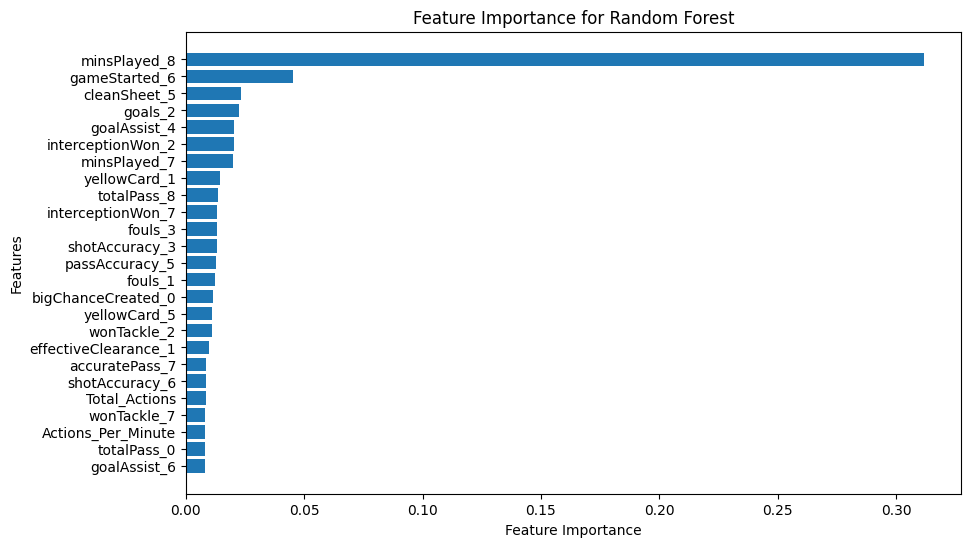

In [21]:
import matplotlib.pyplot as plt


# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [22]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

model1 = Ridge()
model2 = RandomForestRegressor()
model3 = SVR()

ensemble_model = VotingRegressor(estimators=[('ridge', model1), ('rf', model2), ('svr', model3)])
ensemble_model.fit(X_train, y_train)

y_pred_ens = ensemble_model.predict(X_test)

In [23]:
# Evaluate
mse = mean_squared_error(y_test, y_pred_ens)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 20.984137004731252
